In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import scikeras
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.constraints import MaxNorm

from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('../Real_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

,Q_entrada,NH_entrada,TSS_entrada,DQO_entrada,DBO_entrada,TN_entrada,TP_entrada,DQO_saida,Nitrato_saida,Amonia_saida
Dia,,,,,,,,,,
0,4719.000000,21.000000,271.000000,391.000000,198.575000,34.060000,8.020000,33.0,10.8,0.6
1,5866.458829,22.000327,276.000327,399.999347,203.059809,35.360294,8.099990,35.0,12.0,0.5
2,5358.157069,23.998870,281.996233,406.995103,206.957307,37.558734,8.149966,37.0,14.0,0.5
3,5266.313109,22.999791,278.000209,401.000418,203.710285,36.399787,8.109998,39.0,14.0,0.5
4,6671.931586,21.000432,274.999568,396.999136,201.824410,34.220441,8.060004,41.0,14.0,0.5
...,...,...,...,...,...,...,...,...,...,...
360,5120.341705,20.998558,184.998558,266.997116,135.395000,29.898501,6.929986,36.0,12.6,2.1
361,5587.915779,22.000000,182.001170,263.000000,134.093479,30.780012,6.900000,36.0,12.8,1.7
362,5984.690649,22.998229,179.999646,259.000354,131.495253,31.668215,6.869996,37.0,13.0,1.4


In [4]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Nitrato_saida',
            'Amonia_saida',
            'TP_entrada',
            'DQO_entrada',
            'DBO_entrada',], axis=1)

print("X", X.shape)
print("y", y.shape)
print(X.columns)

X (365, 4)
y (365,)
Index(['Q_entrada', 'NH_entrada', 'TSS_entrada', 'TN_entrada'], dtype='object')


In [5]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (30, 4)
Test set y (30,)


In [6]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [7]:
def create_model(neurons, weight_constraint, dropout_rate=0.0, activation='relu', init_mode='uniform'):
 # create model
 model = Sequential()
 model.add(Dense(neurons, input_shape=(4,), kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
 model.add(Dropout(dropout_rate))
 model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
 model.add(Dropout(dropout_rate))
#  model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
#  model.add(Dropout(dropout_rate))
#  model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
#  model.add(Dropout(dropout_rate))
 model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
 # Compile model (only when not looking for best optimizer)
 model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_absolute_percentage_error"])
 return model
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=15,verbose=0)  

# define the grid search parameters
neurons = [4, 8, 16, 32, 64, 128, 256] #, 20, 30
weight_constraint = [1.0, 3.0, 5.0] #, 2.0, 3.0, 4.0
dropout_rate = [0.0, 0.1, 0.2, 0.5] #, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
# activation = ['relu', 'tanh', 'softmax', 'softplus', 'softsign', 'sigmoid', 'hard_sigmoid', 'linear']
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']  # tem demais
learn_rate = [0.001, 0.01, 0.1] #,0.2, 0.3
param_grid = dict(model__neurons=neurons,  model__weight_constraint=weight_constraint, model__dropout_rate=dropout_rate,
             optimizer__learning_rate=learn_rate,) # model__init_mode=init_mode, model__activation = activation,
            
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid_search.fit(normalized_x_train, normalized_y_train)
cv_results = pd.DataFrame(grid_result.cv_results_)
# summarize results
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']



for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(



 Best hyperparameters:
{'model__dropout_rate': 0.5, 'model__neurons': 8, 'model__weight_constraint': 3.0, 'optimizer__learning_rate': 0.1}
-0.177600 (0.114647) with: {'model__dropout_rate': 0.0, 'model__neurons': 4, 'model__weight_constraint': 1.0, 'optimizer__learning_rate': 0.001}
-0.133056 (0.138722) with: {'model__dropout_rate': 0.0, 'model__neurons': 4, 'model__weight_constraint': 1.0, 'optimizer__learning_rate': 0.01}
-0.111950 (0.119875) with: {'model__dropout_rate': 0.0, 'model__neurons': 4, 'model__weight_constraint': 1.0, 'optimizer__learning_rate': 0.1}
-0.088797 (0.104435) with: {'model__dropout_rate': 0.0, 'model__neurons': 4, 'model__weight_constraint': 3.0, 'optimizer__learning_rate': 0.001}
-0.097411 (0.116511) with: {'model__dropout_rate': 0.0, 'model__neurons': 4, 'model__weight_constraint': 3.0, 'optimizer__learning_rate': 0.01}
-0.148509 (0.111955) with: {'model__dropout_rate': 0.0, 'model__neurons': 4, 'model__weight_constraint': 3.0, 'optimizer__learning_rate': 0

In [8]:
# cv_results.sort_values('rank_test_score')
cv_results.loc[cv_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__dropout_rate,param_model__neurons,param_model__weight_constraint,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
203,5.679824,0.167573,0.27008,0.031329,0.5,8,3.0,0.1,"{'model__dropout_rate': 0.5, 'model__neurons':...",-0.111656,0.032012,-0.068002,-0.197042,0.07255,-0.054427,0.097358,1


In [9]:
# ann_model = create_model(neurons = cv_best_params['model__neurons'],
#     weight_constraint = cv_best_params['model__weight_constraint'],
#     dropout_rate = cv_best_params['model__dropout_rate'])
#     #, learning_rate = cv_best_params   ['optimizer__learning_rate'])

# ann_model.fit(normalized_x_train, normalized_y_train)

In [10]:
# Realizando a predição no teste
# y_test_pred_mlp = ann_model.predict(normalized_x_test)
y_test_pred_mlp = grid_search.predict(normalized_x_test)

# Desnormalização
y_test_pred_mlp = np.array(y_test_pred_mlp).reshape(len(y_test_pred_mlp),1)
y_test_pred_mlp = scalery.inverse_transform(y_test_pred_mlp)
y_test_pred_mlp = pd.DataFrame(y_test_pred_mlp, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_mlp = y_test_pred_mlp.squeeze()

y_test_pred_mlp


# Análise dos erros das previsões
rmse_test_mlp = math.sqrt(mean_squared_error(y_test, y_test_pred_mlp))
mae_test_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
mape_test_mlp = mean_absolute_percentage_error(y_test, y_test_pred_mlp)
r2_test_mlp = r2_score(y_test, y_test_pred_mlp)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_mlp], 'MAE':[mae_test_mlp], 'MAPE':[mape_test_mlp],'R²':[r2_test_mlp]})
df_metricas

,RSME,MAE,MAPE,R²
0,16.944879,13.410715,0.234077,0.514858


In [11]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
y_test_pred_df = pd.Series(y_test_pred_mlp,index=y_test.index)
df_comparacao = pd.concat([y_test,y_test_pred_df],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

,Valor_Real,Valor_Predito,Diferenca_percentual
Dia,,,
335,75.0,83.903999,11.871999
336,92.0,99.169220,7.792630
337,71.0,99.649887,40.351954
338,59.0,99.649887,68.898114
339,73.0,99.649887,36.506695
340,87.0,99.649887,14.540100
341,101.0,99.649887,-1.336745
342,126.0,93.308220,-25.945857
343,60.0,99.649887,66.083145


        RSME        MAE      MAPE        R²
0  16.944879  13.410715  0.234077  0.514858


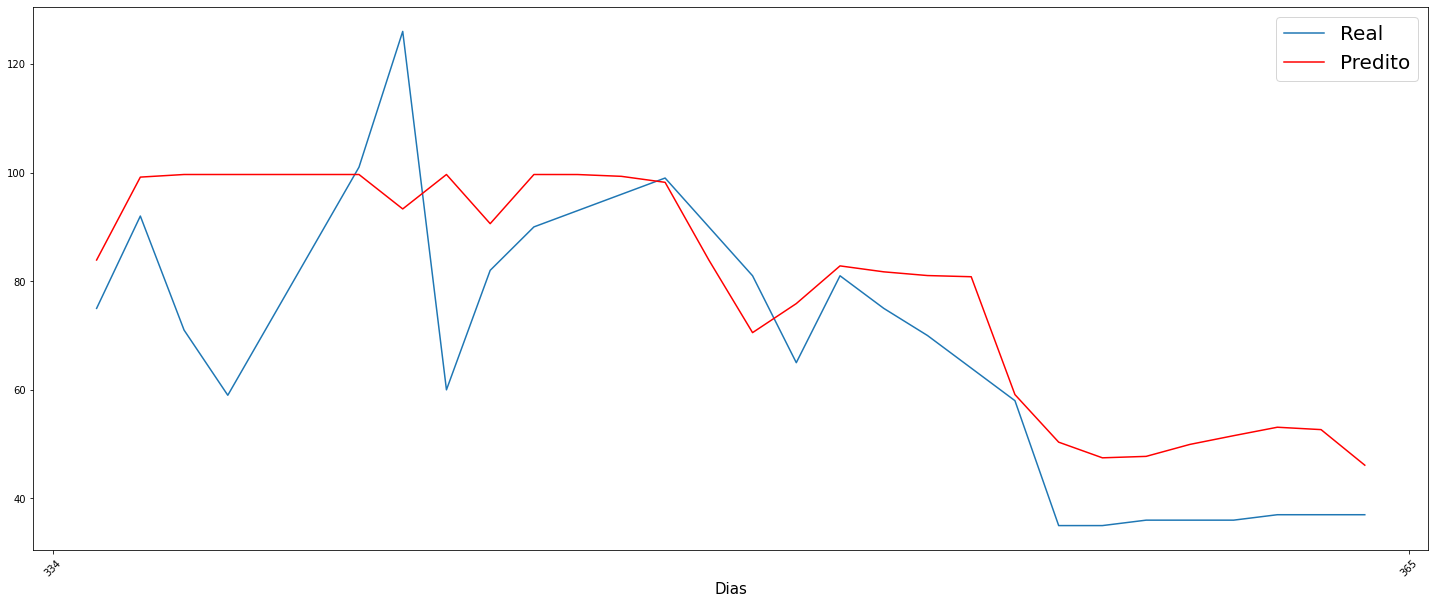

In [71]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [72]:
df_comparacao.to_csv("1_4-Previsoes_Keras_ANN.csv",encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME        MAE      MAPE       R²
0  37.048235  23.362451  0.260971  0.15973


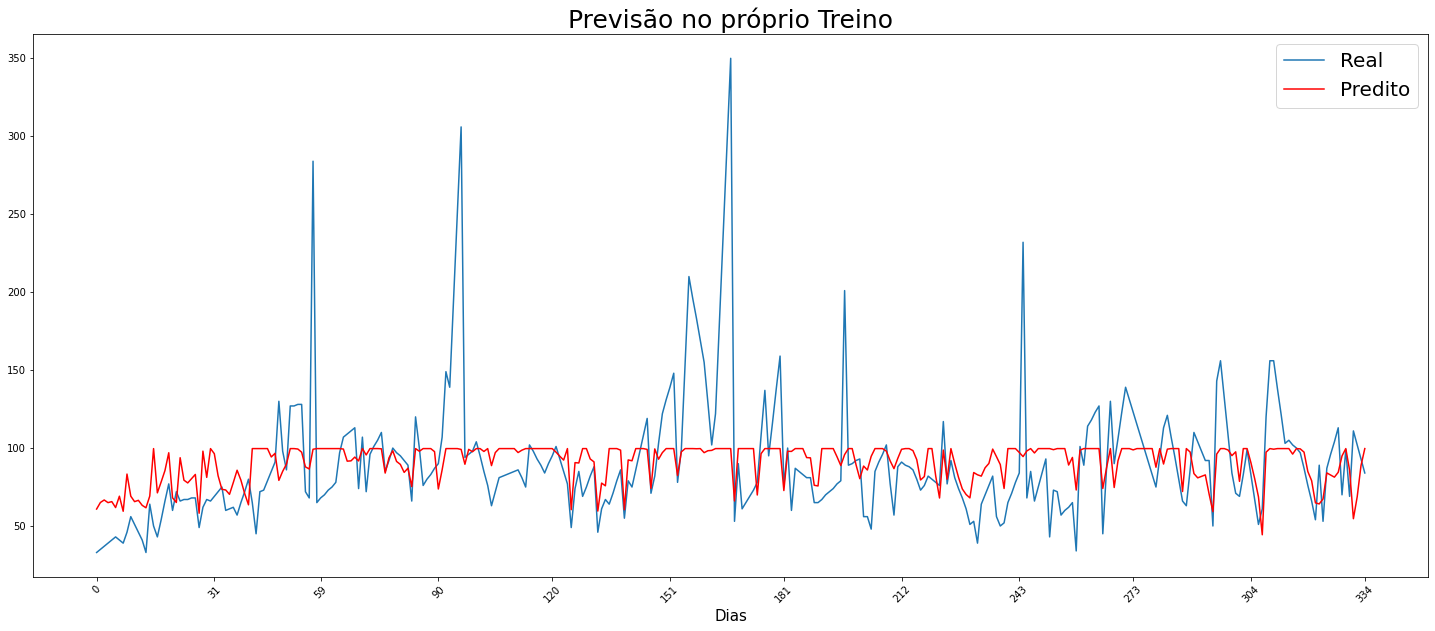

In [73]:
# Realizando a predição no traine
y_train_pred_mlp = grid_search.predict(normalized_x_train)

# Desnormalização
y_train_pred_mlp = np.array(y_train_pred_mlp).reshape(len(y_train_pred_mlp),1)
y_train_pred_mlp = scalery.inverse_transform(y_train_pred_mlp)
y_train_pred_mlp = pd.DataFrame(y_train_pred_mlp, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_mlp = y_train_pred_mlp.squeeze()

y_train_pred_mlp


# Análise dos erros das previsões
rmse_train_mlp = math.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
mape_train_mlp = mean_absolute_percentage_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_mlp],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_mlp], 'MAE':[mae_train_mlp], 'MAPE':[mape_train_mlp],'R²':[r2_train_mlp]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
plt.title('Previsão no próprio Treino', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [74]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_4-Previsoes_TREINO_Keras_ANN.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [75]:
print(X_training.min())
print(X_training.max())

Q_entrada      3183.358416
NH_entrada        8.001139
TSS_entrada     150.178049
TN_entrada       22.240351
dtype: float64
Q_entrada      13259.856413
NH_entrada        68.927897
TSS_entrada     1033.632832
TN_entrada        88.642819
dtype: float64


In [76]:
# Calculate baseline metric
baseline_preds = grid_search.predict(normalized_x_test)
baseline_metric = mean_squared_error(y_test, baseline_preds)

In [77]:
# Calculate feature importance via permutation importance
n_permutations = 30
feature_importance = np.zeros(normalized_x_test.shape[1])
for _ in range(n_permutations):
    for feature_idx in range(normalized_x_test.shape[1]):
        # Create a copy of the test set with shuffled values for the feature
        shuffled_test_X = normalized_x_test.copy()
        shuffled_test_X = shuffled_test_X.to_numpy()
        
        np.random.shuffle(shuffled_test_X[:, feature_idx])

        # Compute predictions and metric for the shuffled data
        shuffled_preds = grid_search.predict(shuffled_test_X)
        shuffled_metric = mean_squared_error(y_test, shuffled_preds)

        # Calculate the feature importance for this permutation
        importance = baseline_metric - shuffled_metric
        feature_importance[feature_idx] += importance

# Average the feature importance over the permutations
feature_importance /= n_permutations

In [78]:
# Print the feature importances
for feature_idx, importance in enumerate(feature_importance):
    print(f"{df.columns[feature_idx]}: Importance = {abs(importance)}")

Q_entrada: Importance = 1.9580896438848867
NH_entrada: Importance = 0.13222514265947513
TSS_entrada: Importance = 6.434303522903125
DQO_entrada: Importance = 0.7580966918232358


In [79]:
importance_df = pd.DataFrame(feature_importance,index=X.columns)
importance_df = importance_df.sort_values(by=0)
importance_df = importance_df/importance_df.sum()
importance_df

,0
TSS_entrada,0.713475
Q_entrada,0.217125
TN_entrada,0.084062
NH_entrada,-0.014662


In [80]:
importance_df.to_csv('3_4-Permutation_Importance_Keras_ANN.csv',sep=';',decimal=',',encoding='utf-8-sig')

In [81]:
def calculate_pdp(feature_idx):
    # Select the feature for which you want to calculate the partial dependence
    normalized_x_train_array = normalized_x_test.copy()
    normalized_x_train_array = normalized_x_train_array.to_numpy()
    selected_feature = normalized_x_train_array[:,feature_idx]

    # Create a grid of values for the selected feature
    grid_values = np.linspace(selected_feature.min(), selected_feature.max(), num=100)

    # Create a copy of the prepared dataset
    modified_data = np.copy(normalized_x_train)

    pdp_values = []
    
    # Replace feature values and generate predictions for each grid value
    for value in grid_values:
        modified_data[:, feature_idx] = value
        modified_predictions = grid_search.predict(modified_data)

        # Calculate the average predictions
        average_predictions = np.mean(modified_predictions)

        pdp_values.append(average_predictions)

    return pdp_values

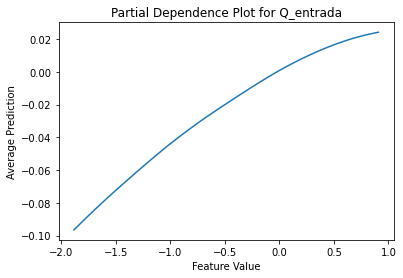

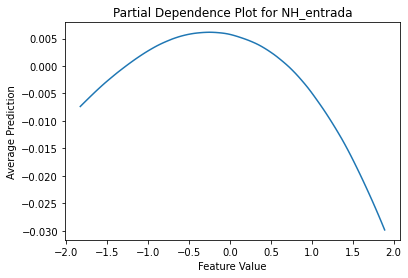

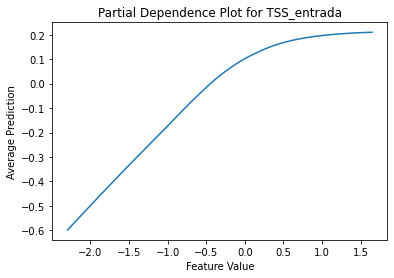

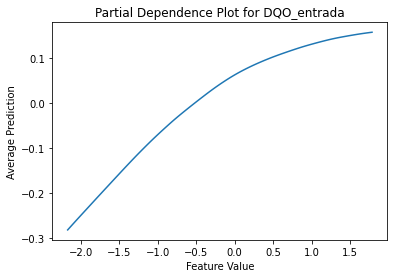

In [82]:
all_pdp_values = []
num_features = normalized_x_train.shape[1]  # Number of features in the data
pdp_intervals = []

# Calculate PDP values for all features
for feature_idx in range(num_features):
    pdp_values = calculate_pdp(feature_idx)
    all_pdp_values.append(pdp_values)

# Plot the PDPs for all features
for feature_idx, pdp_values in enumerate(all_pdp_values):
    normalized_x_train_array = normalized_x_test.copy()
    normalized_x_train_array = normalized_x_train_array.to_numpy()
    grid_values = np.linspace(normalized_x_train_array[:, feature_idx].min(), normalized_x_train_array[:, feature_idx].max(), num=100)
    pdp_intervals.append(grid_values)
    
    plt.plot(grid_values, pdp_values)
    plt.xlabel('Feature Value')
    plt.ylabel('Average Prediction')
    plt.title('Partial Dependence Plot for {}'.format(df.columns[feature_idx]))
    plt.show()

In [83]:
# Values from each variable which have been used to calculate the PDPs
df_pdp_intervals = pd.DataFrame(pdp_intervals).T
df_pdp_intervals.columns = X.columns
df_pdp_intervals = df_pdp_intervals.add_suffix('_values')


# PDP values for each variable
df_pdp_values = pd.DataFrame(all_pdp_values).T
df_pdp_values.columns = X.columns
df_pdp_values = df_pdp_values.add_suffix('_importance')


# Interleave the columns from df_pdp_intervals and df_pdp_values
df_pdp = pd.concat([df_pdp_intervals, df_pdp_values], axis=1)
combined_columns = np.ravel(list(zip(df_pdp.columns[:df_pdp_intervals.shape[1]], df_pdp.columns[df_pdp_intervals.shape[1]:])))

# Rearrange the columns
df_pdp = df_pdp[combined_columns]

df_pdp.to_csv("4_4-PDPs_Keras_ANN.csv",sep=';',decimal=',',encoding='utf-8-sig')

df_pdp

,Q_entrada_values,Q_entrada_importance,NH_entrada_values,NH_entrada_importance,TSS_entrada_values,TSS_entrada_importance,TN_entrada_values,TN_entrada_importance
0,-1.885809,-0.096543,-1.829527,-0.007365,-2.294579,-0.598618,-2.169721,-0.282202
1,-1.857600,-0.094685,-1.791955,-0.006806,-2.254748,-0.585106,-2.129794,-0.274575
2,-1.829391,-0.092835,-1.754382,-0.006253,-2.214917,-0.571601,-2.089868,-0.267004
3,-1.801182,-0.091000,-1.716809,-0.005707,-2.175087,-0.558112,-2.049942,-0.259464
4,-1.772973,-0.089171,-1.679236,-0.005166,-2.135256,-0.544643,-2.010015,-0.251967
...,...,...,...,...,...,...,...,...
95,0.794049,0.022575,1.739903,-0.024579,1.489332,0.208344,1.623276,0.154301
96,0.822258,0.023009,1.777476,-0.025853,1.529162,0.208883,1.663202,0.155317
97,0.850467,0.023419,1.815049,-0.027152,1.568993,0.209391,1.703129,0.156273
98,0.878676,0.023815,1.852622,-0.028478,1.608823,0.209861,1.743055,0.157200
